In [235]:
%load_ext autoreload
%autoreload 2

import sys

import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Rectangle


sys.path.append("src.py")
from src import Utils

# get phospho data by itself
ptp_data = pd.read_pickle("./data/datasets/islets_PTP_dataset.pkl")
ptp_sample_metadata = pd.read_pickle("./data/datasets/islets_PTP_sample_metadata.pkl")
ptp_feature_metadata = pd.read_pickle("./data/datasets/islets_PTP_feature_metadata.pkl")

# get Mouse to Human gene mapping from the ENSEMBL databaset:
mapping_dict_name = "2025-04-30_10_37_56_hsapiens_ref_dict.pkl"
if not os.path.exists("2025-04-30_10_37_56_hsapiens_ref_dict.pkl"):
    mapping_dict_name = f"./{pd.Timestamp.now().strftime('%Y-%m-%d_%H_%M_%S')}_hsapiens_ref_dict.pkl"
    hsapiens_ref_dict = Utils.map_ensembl_to_uniprot('hsapiens', True)
    pd.DataFrame.from_dict(hsapiens_ref_dict, orient = 'index', columns = ['uniprot_id']).to_pickle(mapping_dict_name)

# http://www.ensembl.org/biomart/martview/775974b699d308980b35a596a385b751?VIRTUALSCHEMANAME=default&ATTRIBUTES=mmusculus_gene_ensembl.default.homologs.ensembl_gene_id|mmusculus_gene_ensembl.default.homologs.ensembl_gene_id_version|mmusculus_gene_ensembl.default.homologs.ensembl_transcript_id|mmusculus_gene_ensembl.default.homologs.ensembl_transcript_id_version|mmusculus_gene_ensembl.default.homologs.hsapiens_homolog_ensembl_gene|mmusculus_gene_ensembl.default.homologs.hsapiens_homolog_associated_gene_name|mmusculus_gene_ensembl.default.homologs.hsapiens_homolog_perc_id|mmusculus_gene_ensembl.default.homologs.hsapiens_homolog_ensembl_peptide|mmusculus_gene_ensembl.default.homologs.hsapiens_homolog_orthology_type|mmusculus_gene_ensembl.default.homologs.hsapiens_homolog_orthology_confidence|mmusculus_gene_ensembl.default.homologs.external_gene_name&FILTERS=&VISIBLEPANEL=resultspanel
mouse2human = pd.read_csv("./mouse2human_ortholog_mapping.txt", header = 0).dropna(subset=["Human gene name"])

# Handle mapping of ENSEMBL to uniprot IDs using bioMart. Prefer static version of mapping dict due to possible API changes
mapping_dict_name = "2025-04-30_10_37_56_hsapiens_ref_dict.pkl"
hsapiens_ref_dict = pd.read_pickle(mapping_dict_name)['uniprot_id'].to_dict()

mouse2human = Utils.add_human_uniprot_ids_to_mouse2human(mouse2human, hsapiens_ref_dict)
ptp_feature_metadata = Utils.add_human_uniprot_ids_to_feature_metadata(mouse2human, ptp_feature_metadata)

if not ptp_feature_metadata.index.equals(ptp_data.columns):
    raise ValueError("Alignment between features and data broken")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### [F10] Phosphoproteomics 

Visualize phosphoproteomics differential results alongside functional score annotations


In [236]:
# ttest comparison between cell types (control only) for phospho data
ph_diff_exp = {}
for modality in ['proteomics', 'phosphoproteomics', 'transcriptomics']:
    for comparison in [['alpha','delta'], ['beta', 'delta'], ['alpha', 'beta']]:
        # Importantly, only consider control samples as no treatment was acquired in phospho data
        mask = ptp_sample_metadata['sample'].isin(comparison).values & ptp_sample_metadata['readout'].isin([modality]).values & ptp_sample_metadata['treat'].isin(['control']).values
        if sum(mask) != 6:
            raise ValueError(f"Expected 6 samples for {modality} {comparison} but got {sum(mask)}")
        ph_diff_exp[f"{modality}_{comparison[0]}_over_{comparison[1]}"] = Utils.group_ratios_ttest_ind(
            ptp_data[mask],
            ptp_sample_metadata[mask],
            between = 'sample'
        ).join(
            ptp_feature_metadata,
            how = 'left'
        )


In [237]:
# Data for 2D scatter plot of phosphoproteomics data and proteomics data
volcanoplot_datasets = {}
for comparison in [['alpha','delta'], ['beta', 'delta'], ['alpha', 'beta']]:

    key = f"{comparison[0]}_over_{comparison[1]}"
    columns = [f"delta_{key}", f"pvalue_{key}", f"padj_{key}", f"n_{comparison[0]}", f"n_{comparison[1]}"]

    phospho_data = ph_diff_exp[f"phosphoproteomics_{key}"][columns + ptp_feature_metadata.columns.tolist()]
    phospho_data.columns = [f"phosphoproteomics_{col}" for col in phospho_data.columns]
    proteomics_data = ph_diff_exp[f"proteomics_{key}"][columns]
    proteomics_data.columns = [f"proteomics_{col}" for col in proteomics_data.columns]
    
    combined_data = phospho_data.join(proteomics_data, how = 'inner')
    volcanoplot_datasets[key] = combined_data

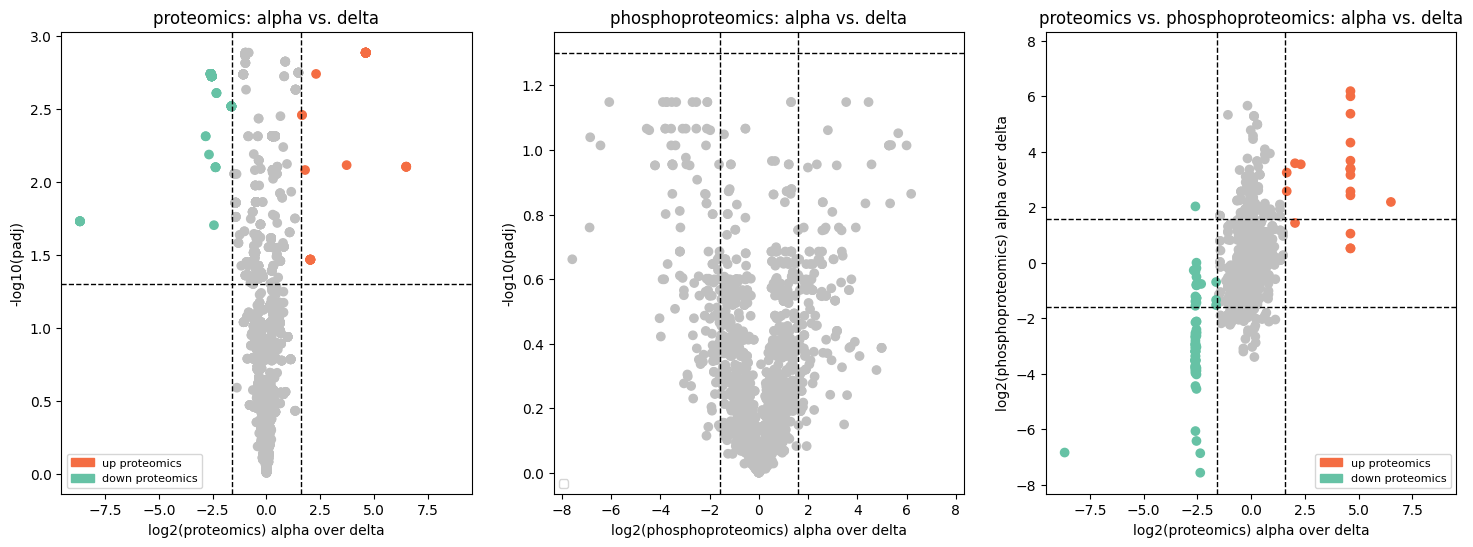

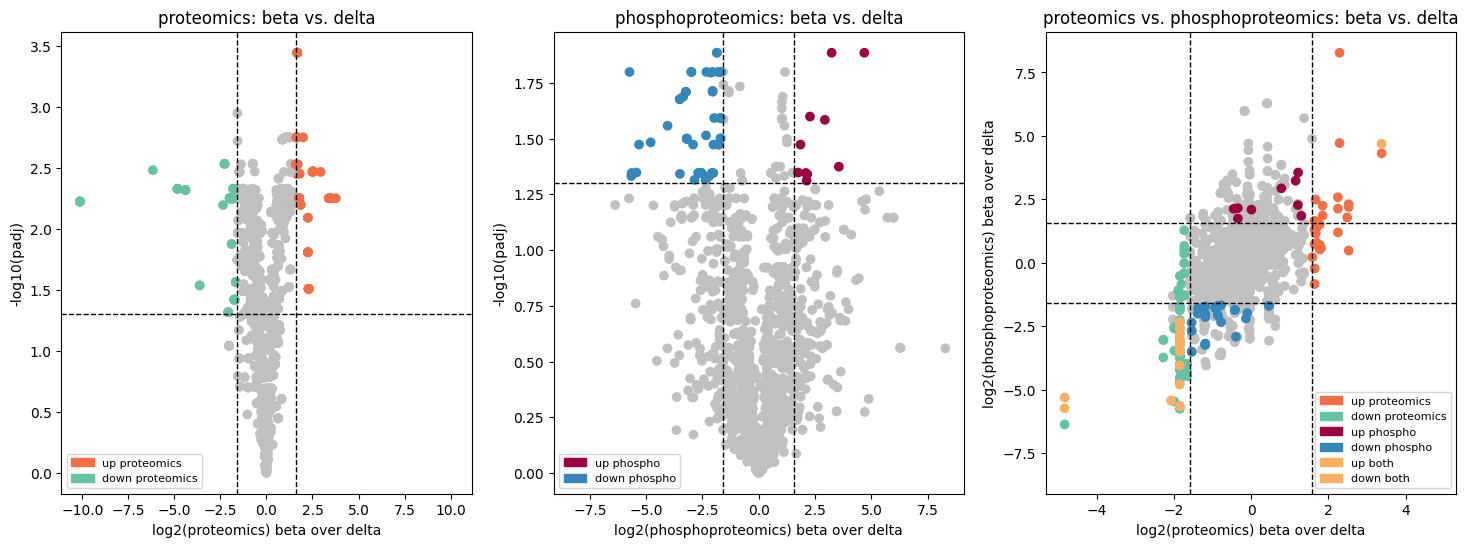

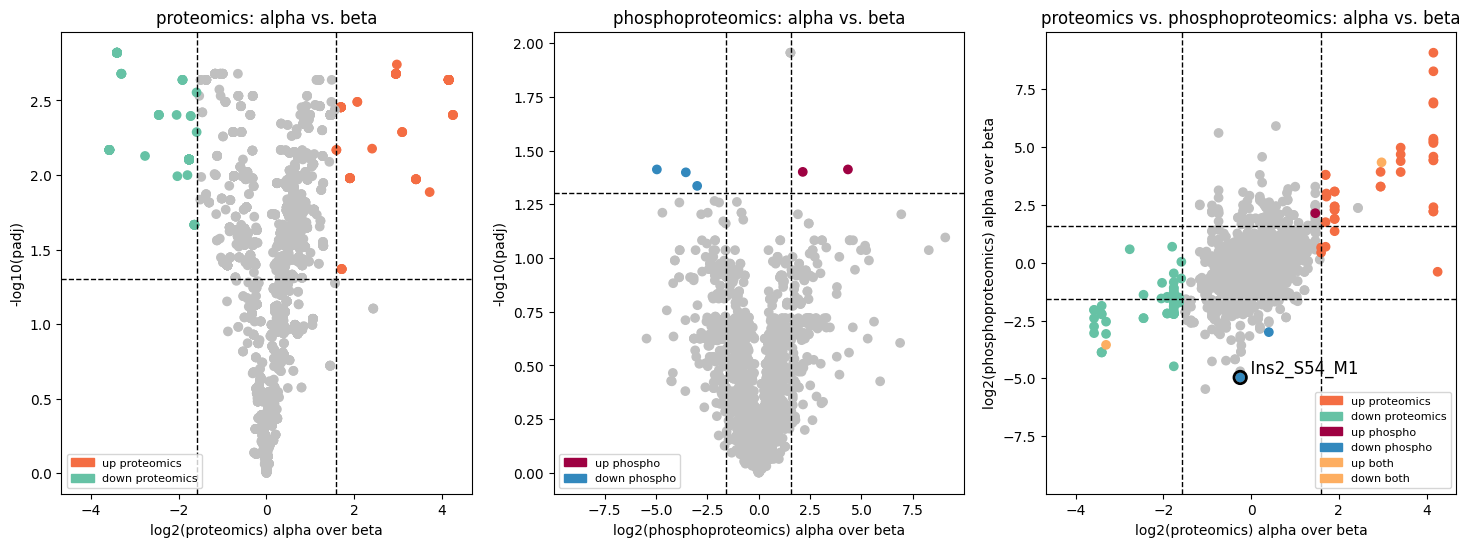

In [238]:
# 2D scatterplotting of phosphoproteomics data and proteomics data
P_LIM = 0.05
X_LIM = np.log2(3)
LINEWIDTH = 1

colormap = {
    'not regulated': '#C0C0C0',
    #
    'upregulated_proteomics': '#f46d43',
    'downregulated_proteomics': '#66c2a5',
    'upregulated_phosphoproteomics': '#9e0142',
    'downregulated_phosphoproteomics': '#3288bd',
    #
    'upregulated_proteomics_phosphoproteomics': '#fdae61',
    'downregulated_proteomics_phosphoproteomics': '#fdae61',
    'selected' : '#fdae61',
}

pvalue = "padj" # or "pvalue"

independent_phospho_sites = {}
for key, df in volcanoplot_datasets.items():
    
    # visualize and extract differentially regulated proteins
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    def sort_df_by_class_frequency(df, col, ascending=False):
        freq = df[col].value_counts(ascending=ascending)
        order_map = {k: i for i, k in enumerate(freq.index)}
        return df.sort_values(by=col, key=lambda x: x.map(order_map))

    def _normal_volcanoplot(ax, df, readout, key):
        df = df.copy()

        # Specify axes
        x_col = f'{readout}_delta_{key}'
        y_col = f'{readout}_{pvalue}_{key}'

        # There need to be values in both columns
        df = df[(~df[x_col].isna()) & (~df[y_col].isna())]

        # Add columns
        df[f'neg_log10_{y_col}'] = -np.log10(df[y_col])
        df['regulated'] = 'not regulated'
        df.loc[((df[x_col] > X_LIM) & (df[y_col] < P_LIM)), 'regulated'] = f'upregulated_{readout}'
        df.loc[((df[x_col] < -X_LIM) & (df[y_col] < P_LIM)), 'regulated'] = f'downregulated_{readout}'

        # plot volcano plot
        reg_colors = df['regulated'].map(colormap)
        ax.scatter(df[x_col], df[f'neg_log10_{y_col}'], c=reg_colors)
        x_outer = max(np.abs(df[x_col])) * 1.1
        ax.set_xlim(-x_outer, x_outer)
        
        ax.axhline(y=-np.log10(P_LIM), color='black', linestyle='--', linewidth=LINEWIDTH)
        ax.axvline(x=X_LIM, color='black', linestyle='--', linewidth=LINEWIDTH)
        ax.axvline(x=-X_LIM, color='black', linestyle='--', linewidth=LINEWIDTH)

        ax.set_xlabel(f'log2({readout}) {" ".join(key.split("_"))}')
        ax.set_ylabel(f'-log10({pvalue})')

        ax.set_title(f'{readout}: {key.replace("_over_", " vs. ")}')

        # Create a legend
        actual_colormap = {k: v for k, v in colormap.items() if k in df['regulated'].unique()}
        actual_colormap.pop('not regulated')
        legend_patches = []
        for label, color in actual_colormap.items():
            legend_patches.append(Patch(color=color, label=label.replace('_',' ').replace('regulated', '').replace('phosphoproteomics', 'phospho')))
        ax.legend(handles=legend_patches, loc='lower left', fontsize=8, frameon=True)

    def _correlation_scatter(ax, df, readout_x, readout_y, key):
        df = df.copy()

        # Specify axes
        x_col = f'{readout_x}_delta_{key}'
        x_sign_col = f'{readout_x}_{pvalue}_{key}'
        y_col = f'{readout_y}_delta_{key}'
        y_sign_col = f'{readout_y}_{pvalue}_{key}'

        # There need to be values in all columns
        df = df[(~df[x_col].isna()) & (~df[y_col].isna()) & (~df[x_sign_col].isna()) & (~df[y_sign_col].isna())]
        
        df['regulated'] = 'not regulated'

        # Basic regulation on each axis
        x_up = (df[x_col] > X_LIM) & (df[x_sign_col] < P_LIM)
        x_down = (df[x_col] < -X_LIM) & (df[x_sign_col] < P_LIM)
        y_up = (df[y_col] > X_LIM) & (df[y_sign_col] < P_LIM)
        y_down = (df[y_col] < -X_LIM) & (df[y_sign_col] < P_LIM)
        df.loc[x_up, 'regulated'] = f'upregulated_{readout_x}'
        df.loc[x_down, 'regulated'] = f'downregulated_{readout_x}'
        df.loc[y_up, 'regulated'] = f'upregulated_{readout_y}'
        df.loc[y_down, 'regulated'] = f'downregulated_{readout_y}'

        # Override basic cases with xy regulation
        xy_up = x_up & y_up
        xy_down = x_down & y_down
        df.loc[xy_up, 'regulated'] = f'upregulated_{readout_x}_{readout_y}'
        df.loc[xy_down, 'regulated'] = f'downregulated_{readout_x}_{readout_y}'
        
        # Reorder the dataframe to get rarest cases first
        df = sort_df_by_class_frequency(df, 'regulated')

        # plot correlation scatter
        reg_colors = df['regulated'].map(colormap)
        ax.scatter(df[x_col], df[y_col], c=reg_colors.values)

        # Special attention on phosphorylation without proteome regulation
        only_y_regulated = (y_up | y_down) & ~(x_up | x_down)
        independent_phospho_sites[key] = df.loc[only_y_regulated,:].copy()
        
        x_outer = max(np.abs(df[x_col])) * 1.1
        ax.set_xlim(-x_outer, x_outer)
        
        y_outer = max(np.abs(df[y_col])) * 1.1
        ax.set_ylim(-y_outer, y_outer)

        [ax.axhline(y=x, color='black', linestyle='--', linewidth=LINEWIDTH) for x in [X_LIM,-X_LIM]]
        [ax.axvline(x=x, color='black', linestyle='--', linewidth=LINEWIDTH) for x in [X_LIM,-X_LIM]]

        ax.set_xlabel(f'log2({readout_x}) {" ".join(key.split("_"))}')
        ax.set_ylabel(f'log2({readout_y}) {" ".join(key.split("_"))}')
        ax.set_title(f'{readout_x} vs. {readout_y}: {key.replace("_over_", " vs. ")}')

        # Create a legend
        actual_colormap = {k: v for k, v in colormap.items() if k in df['regulated'].unique()}
        actual_colormap.pop('not regulated')
        legend_patches = []
        for label, color in actual_colormap.items():
            legend_patches.append(Patch(
                color=color, 
                label=label.replace('_',' ').replace('regulated', '').replace('phosphoproteomics', 'phospho').replace('down proteomics phospho', 'down both').replace('up proteomics phospho', 'up both')))
        ax.legend(handles=legend_patches, loc='lower right', fontsize=8, frameon=True)

        # Add a label for the independent phospho sites
        for i, row in df.loc[only_y_regulated,:].iterrows():
            if "Ins2" in row['phosphoproteomics_PTM_collapse_key']:
                ax.text(row[x_col], row[y_col], f"  {row['phosphoproteomics_PTM_collapse_key']}", fontsize=12, ha='left', va='bottom', color='black')
                ax.scatter(row[x_col], row[y_col], s=80, facecolors='none', edgecolors='black', linewidth=2)

    for i, readout in enumerate([['proteomics'], ['phosphoproteomics'], ['proteomics', 'phosphoproteomics']]):
        if len(readout) == 1:
            readout = readout[0]
            _normal_volcanoplot(axs[i], df, readout, key)
        else:
            readout_x = readout[0]
            readout_y = readout[1]
            _correlation_scatter(axs[i], df, readout_x, readout_y, key)

## individually investigating Ins2_S54_M1 for its differential regulation between Alpha and Beta cells

In [240]:
ptp_feature_metadata[ptp_feature_metadata['PG.Genes'] == 'Ins2'] #P01326
display(ptp_data.loc[ptp_data.index.str.contains('beta_control'),'Ins2_S54_M1'])
display(ptp_data.loc[ptp_data.index.str.contains('alpha_control'),'Ins2_S54_M1'])

beta_control_1_phosphoproteomics    10.564698
beta_control_2_phosphoproteomics    11.120097
beta_control_3_phosphoproteomics    10.923804
beta_control_3_proteomics           19.757136
beta_control_2_proteomics           19.859978
beta_control_1_proteomics           19.692416
beta_control_1_transcriptomics      17.821811
beta_control_2_transcriptomics      17.683892
beta_control_3_transcriptomics      18.136080
Name: Ins2_S54_M1, dtype: float64

alpha_control_1_phosphoproteomics     5.505626
alpha_control_2_phosphoproteomics     5.949287
alpha_control_3_phosphoproteomics     6.271688
alpha_control_3_proteomics           19.874681
alpha_control_2_proteomics           19.712666
alpha_control_1_proteomics           18.973868
alpha_control_1_transcriptomics      12.387282
alpha_control_2_transcriptomics      13.701333
alpha_control_3_transcriptomics      15.612543
Name: Ins2_S54_M1, dtype: float64

## Retrieve functional annotation from literature data

To gain functional insight into observed phosphorylation sites, we next sought to map mouse phosphorylation sites to their ortholog function in human. First, we obtained human ortholog UniProtIDs from ENSEMBL. Next, we performed pairwise sequence alignment between mouse genes and orthologs to pinpoint the corresponding human phosphorylation site. Finally, we sought to put these PTMs into functional context by referencing a landmark study by Ochoa et al., which mapped phosphorylation sites across the human proteome to function.

In [337]:
from Bio import SeqIO, pairwise2
from io import StringIO
from Bio.pairwise2 import format_alignment

# Load human and mouse fasta files, keep in memory as lists
human_fasta_path = "uniprotkb_human_AND_model_organism_9606_2025_05_01.fasta"
human_proteome = [x for x in SeqIO.parse(human_fasta_path, "fasta")]

mouse_fasta_path = "uniprotkb_10090_AND_model_organism_1009_2025_05_01.fasta"
mouse_proteome = [x for x in SeqIO.parse(mouse_fasta_path, "fasta")]

# Function to get protein sequence from a list of SeqIO records
def get_protein_sequence(id, proteome):
    seq = ""
    for record in proteome:
        if record.id.split("|")[1] == id:
            seq = str(record.seq)
            break
    return seq

# Function to align mouse protein to human protein based on their IDs matched to the SeqIO records
def best_alignment_mouse_to_human(mouse_id, human_id, mouse_proteome, human_proteome):
    mouse_protein = get_protein_sequence(mouse_id, mouse_proteome)
    human_protein = get_protein_sequence(human_id, human_proteome)

    print(f"Mouse protein sequence for {mouse_id}: {mouse_protein}")
    print(f"Human protein sequence for {human_id}: {human_protein}")

    alignments = pairwise2.align.globalxx(mouse_protein, human_protein)
    return alignments[0]

In [327]:
example_mouse_id = independent_phospho_sites['alpha_over_beta']['phosphoproteomics_PG.UniProtIds'].iloc[0]
example_human_id = independent_phospho_sites['alpha_over_beta']['phosphoproteomics_human_UniProtID'].iloc[0]


In [343]:
get_protein_sequence(example_mouse_id, mouse_proteome)[53]

'S'

In [331]:
get_protein_sequence(example_human_id, human_proteome)

'MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGGGPGAGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN'

In [339]:
alignment = best_alignment_mouse_to_human(example_mouse_id, example_human_id, mouse_proteome, human_proteome)

Mouse protein sequence for P01326: MALWMRFLPLLALLFLWESHPTQAFVKQHLCGSHLVEALYLVCGERGFFYTPMSRREVEDPQVAQLELGGGPGAGDLQTLALEVAQQKRGIVDQCCTSICSLYQLENYCN
Human protein sequence for I3WAC9: MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGGGPGAGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN


In [340]:
alignment

Alignment(seqA='MALWMRFL-PLLALLF-LWESH-PTQ--A--FVK-QHLCGSHLVEALYLVCGERGFFYTPMS--RREV-EDP-QVA-QL-ELGGGPGAGD-LQT-LALEVAQ---QKRGIVD-QCCTSICSLYQLENYCN', seqB='MALWMR-LLPLLALL-ALW---GP--DPAAAFV-NQHLCGSHLVEALYLVCGERGFFYTP--KTRRE-AED-LQV-GQ-VELGGGPGAG-SLQ-PLALE---GSLQKRGIV-EQCCTSICSLYQLENYCN', score=90.0, start=0, end=130)

In [341]:
independent_phospho_sites['alpha_over_beta']

,phosphoproteomics_delta_alpha_over_beta,phosphoproteomics_pvalue_alpha_over_beta,phosphoproteomics_padj_alpha_over_beta,phosphoproteomics_n_alpha,phosphoproteomics_n_beta,phosphoproteomics_PG.UniProtIds,phosphoproteomics_R.Condition,phosphoproteomics_PG.Genes,phosphoproteomics_PG.Organisms,phosphoproteomics_PG.ProteinDescriptions,...,phosphoproteomics_PTM_localization,phosphoproteomics_PTM_0_aa,phosphoproteomics_Gene name,phosphoproteomics_human_UniProtID,proteomics_delta_alpha_over_beta,proteomics_pvalue_alpha_over_beta,proteomics_padj_alpha_over_beta,proteomics_n_alpha,proteomics_n_beta,regulated
Ins2_S54_M1,-4.960666,0.000103,0.038733,3,3,P01326,Not Defined,Ins2,Mus musculus,Insulin-2,...,1.0,S,Ins2,I3WAC9,-0.249438,0.464319,0.504617,3,3,downregulated_phosphoproteomics
Slc16a10_S501_M2,-2.999557,0.000225,0.046197,3,3,Q3U9N9,Not Defined,Slc16a10,Mus musculus,Monocarboxylate transporter 10,...,1.0,S,Slc16a10,Q8TF71,0.403682,0.125339,0.161453,3,3,downregulated_phosphoproteomics
Top2b_S1453_M1,2.141121,0.000145,0.039764,3,3,Q64511,Not Defined,Top2b,Mus musculus,DNA topoisomerase 2-beta,...,1.0,S,Top2b,Q02880,1.462703,0.000411,0.003951,3,3,upregulated_phosphoproteomics
